# Forecast

For practical implementation:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

For theoretical knowledge of spline:
https://timodenk.com/blog/cubic-spline-interpolation/


In [1]:
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
import os
import matplotlib.lines as mlines
import seaborn as sns
from distfit import distfit

In [2]:

desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop') 
#print(os.getcwd())
This_file_path = os.getcwd()
total_string_len = len(This_file_path)
#print(total_string_len)

string_len_to_remove = len("Data Examination")
#print(string_len_to_remove)

path = This_file_path[0:(total_string_len-string_len_to_remove)]
#print(path)
path_processed_data = path + "Processed_data\\"
#print(path_processed_data)

# Set up FCR-D forecast. Mean for the past 5 days.
- At D-2 it is past 5 days, meaning 7 days from what to predict.
- At D-1 it is the past 5 days, meaning 6 days from what to predict

In [3]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
data = data.drop(columns=["Hour"])
True_data = data
True_data_arr = True_data.to_numpy()


In [4]:
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
Total_length_test = len(data["FD1_down"])
forecasted_data = np.zeros(( Total_length_test, len(Forecasts) ))  # (Specific Forecasts, Data size, number of total forecasts )
print(np.shape(forecasted_data))

(10920, 11)


In [5]:
index_FD1_up_percentage = Forecasts.index("FD1_up_percentage")
index_FD1_down_percentage = Forecasts.index("FD1_down_percentage")

D_2_list = [2,3,4,5,6]
start_idx = D_2_list[-1]*24

for col in data.columns:
    index = Forecasts.index(col) # Get the index
    
    # Run mean procedure

    # As the volumes need to add up to 100% then is it only the D-1 which has been forecasted as t
    if 'percentage' in col:
            if "FD2" in col:
                if "up" in col:
                    forecasted_data[:,index] = 1 - forecasted_data[:,index_FD1_up_percentage]
                else:
                    forecasted_data[:,index] = 1 - forecasted_data[:,index_FD1_down_percentage]
                    #forecasted_data.loc[h, col] = 1 - forecasted_data.loc[h, 'FD1_down_percentage']
            else:
                for h in range(start_idx,Total_length_test):
                    value = 0
                    for hd in D_2_list:

                        #print(data.loc[h+8760-hd*24, col])
                        #print(h+8760-hd*24)
                        value = value + data.loc[h-hd*24, col]
                    
                    forecasted_data[h,index] = value/len(D_2_list)

    else:

        for h in range(start_idx,Total_length_test):
            value = 0
            for hd in D_2_list:

                #print(data.loc[h+8760-hd*24, col])
                #print(h+8760-hd*24)
                value = value + data.loc[h-hd*24, col]
            
            forecasted_data[h,index] = value/len(D_2_list)


    print("Forecasts for ", col, " ended")

            
    

Forecasts for  Spot  ended
Forecasts for  FD1_down  ended
Forecasts for  FD2_down  ended
Forecasts for  FD1_up  ended
Forecasts for  FD2_up  ended
Forecasts for  FD1_up_percentage  ended
Forecasts for  FD2_up_percentage  ended
Forecasts for  FD1_down_percentage  ended
Forecasts for  FD2_down_percentage  ended
Forecasts for  FD_act_up  ended
Forecasts for  FD_act_down  ended


In [6]:
F_len = np.size(forecasted_data[:,:],1) # Number of features
T_len = np.size(forecasted_data[:,:],0) # length of test data
Saved_Info = np.zeros((F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for f in range(0,F_len): # For each type of forecast, spot, FD2 Down so forth..

    errors = (True_data_arr[start_idx:,f] - forecasted_data[start_idx:,f])

    MAE_h  =np.abs(errors)
    #MAPE_h = np.abs( (errors) / (True_data_arr[:,f]) ) * 100
    
    #MAPE = np.mean(MAPE_h)
    MAE = np.mean(MAE_h)
    
    #Median_APE = np.median(MAPE_h)
    Median_AE = np.median(MAE_h)

    #Std_APE = np.std(MAPE_h)
    Std_AE = np.std(MAE_h)

    # Save the proper data
    Saved_Info[f,1] = MAE
    Saved_Info[f,2] = Median_AE
    Saved_Info[f,3] = Std_AE

print("Forecast ",F[0],"(",np.round(Saved_Info[0,1]), np.round(Saved_Info[0,2]), np.round(Saved_Info[0,3]),")", "   ",F[1],"(",np.round(Saved_Info[1,1]), np.round(Saved_Info[1,2]), np.round(Saved_Info[1,3]),")", "   ",F[2],"(",np.round(Saved_Info[2,1]), np.round(Saved_Info[2,2]), np.round(Saved_Info[2,3]),")", "   ",F[3],"(",np.round(Saved_Info[3,1]), np.round(Saved_Info[3,2]), np.round(Saved_Info[3,3]),")", "   ",F[4],"(",np.round(Saved_Info[4,1]), np.round(Saved_Info[4,2]), np.round(Saved_Info[4,3]),")")



Forecast  Spot ( 79.0 62.0 69.0 )     FD1_down ( 33.0 9.0 82.0 )     FD2_down ( 7.0 3.0 11.0 )     FD1_up ( 28.0 14.0 41.0 )     FD2_up ( 6.0 3.0 7.0 )


# Create a csv file for forecasted values

In [7]:
F = data.columns
# change forecasted_data_3D to a dataframe
df_forecast = pd.DataFrame(forecasted_data[:,:], columns=F)

#Create csv
csv_name_path = path_processed_data+"forecast_all1.csv"
df_forecast.to_csv(csv_name_path,index=False)

# Create the perfect forecast as well:
csv_name_path = path_processed_data+"forecast_all0.csv"
data.to_csv(csv_name_path,index=False)

In [12]:
datas = pd.read_csv(path_processed_data + 'forecast_all1_test.csv') # Change path
data2s = pd.read_csv(path_processed_data + 'forecast_all1.csv') # Change path
data2s["FD1_up"] - datas["FD1_up"]


0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
10915   -1.193366
10916   -1.683915
10917   -2.290900
10918   -1.922386
10919   -1.562320
Name: FD1_up, Length: 10920, dtype: float64

# Checking accuracy for number of mean horizon forecast configurations

In [59]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
data = data.drop(columns=["Hour"])
True_data = data
True_data_arr = True_data.to_numpy()
Total_length_test = len(data["FD1_down"])


In [14]:
[i for i in range(2,7)]

[2, 3, 4, 5, 6]

In [15]:
#Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up"]
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
back_view = [0,7,41,101]
back_view = [i for i in [0,7,41,101]]
start_idx = [i*24 for i in [0,7,41,101]]
#start_idx = [0,6*24,40*24,100*24]
forecasted_data_3D_test = np.zeros(( Total_length_test, len(Forecasts), len(back_view) ))  # (Specific Forecasts, Data size, number of total forecasts )
for f,col in enumerate(data[Forecasts].columns):
    index = Forecasts.index(col) # Get the index
    print(col)
    

    for n,back in enumerate(back_view):

        if back == 0:
            D_list = [0]
        else:
            D_list = [i for i in range(2,back)]

        for h in range(start_idx[n],Total_length_test):
            value = 0
            for hd in D_list:
                
                value = value + data.loc[h-hd*24, col]
                #print(value)
            
            forecasted_data_3D_test[h,index,n] = value/len(D_list)

Spot
FD1_down
FD2_down
FD1_up
FD2_up
FD1_up_percentage
FD2_up_percentage
FD1_down_percentage
FD2_down_percentage
FD_act_up
FD_act_down


In [16]:
N_len = np.size(forecasted_data_3D_test[:,:,:],2) # Number of forecasts
F_len = np.size(forecasted_data_3D_test[:,:,:],1) # Number of features
T_len = np.size(forecasted_data_3D_test[:,:,:],0) # length of test data
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    for f in range(0,F_len): # For each type of forecast, spot, FD2 Down so forth..
        
        errors = (True_data_arr[:,f] - forecasted_data_3D_test[:,f,n])

        MAE_h  =np.abs(errors)
        #MAPE_h = np.abs( (errors) / (True_data_arr[:,f]) ) * 100
        
        #MAPE = np.mean(MAPE_h)
        MAE = np.mean(MAE_h)
        
        #Median_APE = np.median(MAPE_h)
        Median_AE = np.median(MAE_h)

        #Std_APE = np.std(MAPE_h)
        Std_AE = np.std(MAE_h)
    
            
        # Save the proper data
        Saved_Info[n,f,0] = n
        Saved_Info[n,f,1] = MAE
        Saved_Info[n,f,2] = Median_AE
        Saved_Info[n,f,3] = Std_AE


#print(Saved_Info)


for n in range(0,N_len):
    print("Forecast ",n, "    ",F[0],"(",np.round(Saved_Info[n,0,1]), np.round(Saved_Info[n,0,2]), np.round(Saved_Info[n,0,3]),")", "   ",F[1],"(",np.round(Saved_Info[n,1,1]), np.round(Saved_Info[n,1,2]), np.round(Saved_Info[n,1,3]),")", "   ",F[2],"(",np.round(Saved_Info[n,2,1]), np.round(Saved_Info[n,2,2]), np.round(Saved_Info[n,2,3]),")", "   ",F[3],"(",np.round(Saved_Info[n,3,1]), np.round(Saved_Info[n,3,2]), np.round(Saved_Info[n,3,3]),")", "   ",F[4],"(",np.round(Saved_Info[n,4,1]), np.round(Saved_Info[n,4,2]), np.round(Saved_Info[n,4,3]),")")



Forecast  0      Spot ( 0.0 0.0 0.0 )     FD1_down ( 0.0 0.0 0.0 )     FD2_down ( 0.0 0.0 0.0 )     FD1_up ( 0.0 0.0 0.0 )     FD2_up ( 0.0 0.0 0.0 )
Forecast  1      Spot ( 79.0 62.0 69.0 )     FD1_down ( 33.0 9.0 82.0 )     FD2_down ( 7.0 3.0 12.0 )     FD1_up ( 28.0 14.0 41.0 )     FD2_up ( 7.0 3.0 9.0 )
Forecast  2      Spot ( 100.0 76.0 83.0 )     FD1_down ( 37.0 18.0 81.0 )     FD2_down ( 14.0 8.0 16.0 )     FD1_up ( 33.0 20.0 41.0 )     FD2_up ( 20.0 15.0 15.0 )
Forecast  3      Spot ( 118.0 95.0 96.0 )     FD1_down ( 41.0 27.0 80.0 )     FD2_down ( 20.0 18.0 17.0 )     FD1_up ( 36.0 25.0 42.0 )     FD2_up ( 25.0 20.0 20.0 )


In [17]:
F = data.columns
# change forecasted_data_3D to a dataframe
for n in range(0,N_len): # For each forecast factor
    df_forecast = pd.DataFrame(forecasted_data_3D_test[:,:,n], columns=F)

    #Create csv
    csv_name_path = path_processed_data+"forecast_all"+str(n)+".csv"
    print(csv_name_path)
    df_forecast.to_csv(csv_name_path,index=False)



c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Processed_data\forecast_all0.csv
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Processed_data\forecast_all1.csv
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Processed_data\forecast_all2.csv
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Processed_data\forecast_all3.csv


In [25]:
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up"]
#Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
back_view = [0,6,40,100]
back_view = [i for i in range(0,110,10)]
start_idx = [i*24 for i in range(0,110,10)]
#start_idx = [0,6*24,40*24,100*24]
forecasted_data_3D_test = np.zeros(( Total_length_test, len(Forecasts), len(back_view) ))  # (Specific Forecasts, Data size, number of total forecasts )
for f,col in enumerate(data[Forecasts].columns):
    index = Forecasts.index(col) # Get the index
    print(col)
    

    for n,back in enumerate(back_view):

        if back == 0:
            D_list = [0]
        else:
            D_list = [i for i in range(2,back)]

        for h in range(start_idx[n],Total_length_test):
            value = 0
            for hd in D_list:
                
                value = value + data.loc[h-hd*24, col]
                #print(value)
            
            forecasted_data_3D_test[h,index,n] = value/len(D_list)

Spot
FD1_down
FD2_down
FD1_up
FD2_up


In [41]:
N_len = np.size(forecasted_data_3D_test[:,:,:],2) # Number of forecasts
F_len = np.size(forecasted_data_3D_test[:,:,:],1) # Number of features
T_len = np.size(forecasted_data_3D_test[:,:,:],0) # length of test data
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    for f in range(0,F_len): # For each type of forecast, spot, FD2 Down so forth..
        
        errors = (True_data_arr[:,f] - forecasted_data_3D_test[:,f,n])

        MAE_h  =np.abs(errors)
        #MAPE_h = np.abs( (errors) / (True_data_arr[:,f]) ) * 100
        
        #MAPE = np.mean(MAPE_h)
        MAE = np.mean(MAE_h)
        
        #Median_APE = np.median(MAPE_h)
        Median_AE = np.median(MAE_h)

        #Std_APE = np.std(MAPE_h)
        Std_AE = np.std(MAE_h)
    
            
        # Save the proper data
        Saved_Info[n,f,0] = n
        Saved_Info[n,f,1] = MAE
        Saved_Info[n,f,2] = Median_AE
        Saved_Info[n,f,3] = Std_AE


#print(Saved_Info)


for n in range(0,N_len):
    print("Forecast d:",back_view[n], "    ",F[0],"(",np.round(Saved_Info[n,0,1]), np.round(Saved_Info[n,0,2]), np.round(Saved_Info[n,0,3]),")", "   ",F[1],"(",np.round(Saved_Info[n,1,1]), np.round(Saved_Info[n,1,2]), np.round(Saved_Info[n,1,3]),")", "   ",F[2],"(",np.round(Saved_Info[n,2,1]), np.round(Saved_Info[n,2,2]), np.round(Saved_Info[n,2,3]),")", "   ",F[3],"(",np.round(Saved_Info[n,3,1]), np.round(Saved_Info[n,3,2]), np.round(Saved_Info[n,3,3]),")", "   ",F[4],"(",np.round(Saved_Info[n,4,1]), np.round(Saved_Info[n,4,2]), np.round(Saved_Info[n,4,3]),")")



Forecast d: 0      Spot ( 0.0 0.0 0.0 )     FD1_down ( 0.0 0.0 0.0 )     FD2_down ( 0.0 0.0 0.0 )     FD1_up ( 0.0 0.0 0.0 )     FD2_up ( 0.0 0.0 0.0 )
Forecast d: 10      Spot ( 79.0 61.0 69.0 )     FD1_down ( 33.0 10.0 82.0 )     FD2_down ( 8.0 3.0 13.0 )     FD1_up ( 28.0 14.0 40.0 )     FD2_up ( 8.0 4.0 10.0 )
Forecast d: 20      Spot ( 86.0 64.0 75.0 )     FD1_down ( 35.0 14.0 81.0 )     FD2_down ( 11.0 5.0 15.0 )     FD1_up ( 30.0 17.0 40.0 )     FD2_up ( 12.0 8.0 12.0 )
Forecast d: 30      Spot ( 94.0 72.0 79.0 )     FD1_down ( 36.0 15.0 81.0 )     FD2_down ( 12.0 7.0 16.0 )     FD1_up ( 31.0 18.0 41.0 )     FD2_up ( 16.0 11.0 13.0 )
Forecast d: 40      Spot ( 100.0 76.0 83.0 )     FD1_down ( 37.0 18.0 81.0 )     FD2_down ( 14.0 8.0 16.0 )     FD1_up ( 32.0 19.0 41.0 )     FD2_up ( 19.0 15.0 14.0 )
Forecast d: 50      Spot ( 102.0 79.0 86.0 )     FD1_down ( 39.0 20.0 81.0 )     FD2_down ( 15.0 10.0 17.0 )     FD1_up ( 34.0 21.0 42.0 )     FD2_up ( 21.0 17.0 16.0 )
Forecast d: 60

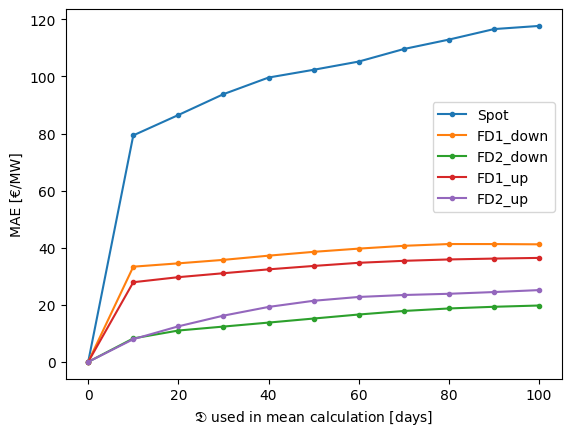

In [49]:
import matplotlib.pyplot as plt
import numpy as np

x = back_view
Forecasts = ["Spot", "FD1_down", "FD2_down", "FD1_up", "FD2_up"]

# Plot for each feature
for f in range(len(Forecasts)):
    MAE_f = Saved_Info[:, f, 1]
    std_f = Saved_Info[:, f, 3]
    
    plt.plot(x, MAE_f, marker='.', label=Forecasts[f])

plt.xlabel('$\mathfrak{D}$ used in mean calculation [days]')
plt.ylabel('MAE [€/MW]')
plt.legend(loc='center right', bbox_to_anchor=(1.0, 0.6))  # Locate the legend to the middle in the right part of the plot
plt.savefig('forecast_mean_D.pdf', format="pdf", bbox_inches="tight")
plt.show()


# Non-linear Feature transformation

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
transformer = PolynomialFeatures(degree=2, include_bias=False)
cols = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up"]

transformed_data = transformer.fit_transform(data[cols])
transformed_cols = transformer.get_feature_names_out(cols).tolist() # Output it as a list and not numpy array
transformed_df = pd.DataFrame(transformed_data, columns=transformed_cols)
transformed_df.to_csv(path_processed_data + "PolynomialFeatures.csv", sep=',', header=True, index_label='Hour')
print(transformed_df)